In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

In [38]:
# Replace with your actual file path if needed
path ='/Users/aniqakhan/Desktop/Dissertation/anes_timeseries_2020_csv_20220210/anes_timeseries_2020_csv_20220210.csv'
df = pd.read_csv(path)

/var/folders/fg/c7wq50ys5g98k_12qph2hgkm0000gn/T/ipykernel_2396/2631509789.py:3: DtypeWarning: Columns (15,17,18,19,21,22,23,25,26,27,29,30,31,33,34,35,37,38,1508,1509) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


In [39]:
# Paste your full variable list here (no duplicates)
selected_vars = [
    'V201005','V201006','V201029','V201030','V201036','V201037','V201045','V201100',
    'V201127','V201128','V201129x','V201130','V201131','V201132x','V201133','V201134',
    'V201135x','V201136','V201137','V201138x','V201139','V201140','V201141x','V201142',
    'V201143','V201144x','V201151','V201152','V201153','V201154','V201155','V201156',
    'V201157','V201200','V201201','V201202','V201203','V201206','V201207','V201208',
    'V201209','V201210','V201211','V201212','V201213','V201214','V201215','V201216',
    'V201228','V201229','V201231x','V201232','V201233','V201234','V201235','V201236',
    'V201238','V201239','V201240','V201241','V201242','V201243','V201244','V201249',
    'V201250','V201251','V201252','V201253','V201254','V201255','V201256','V201257',
    'V201258','V201259','V201260','V201262','V201263','V201264','V201300','V201301',
    'V201302x','V201303','V201304','V201305x','V201306','V201307','V201308x','V201309',
    'V201310','V201311x','V201312','V201313','V201314x','V201318','V201319','V201320x',
    'V201324','V201325','V201326','V201331','V201332','V201333x','V201334','V201335',
    'V201336','V201337','V201338','V201339','V201340','V201341','V201342x','V201343',
    'V201344','V201345x','V201347','V201348','V201350','V201366','V201376','V201373',
    'V201374','V201377','V201381','V201406','V201407','V201408x','V201412','V201415',
    'V201418','V201420x','V201430','V201434','V201435','V201602','V201640','V202013',
    'V202014','V202015','V202016','V202017','V202022','V202023','V202024','V202025',
    'V202029','V202073','V202160','V202161','V202162','V202164','V202165','V202166',
    'V202167','V202168','V202169','V202170','V202171','V202172','V202174','V202175',
    'V202179','V202183','V202243','V202245x','V202256','V202257','V202258','V202326',
    'V202327','V202353','V202429','V202431','V202432','V202433','V202434','V202435',
    'V202436','V202437','V202438','V202439','V202443','V202481','V202482','V202483',
    'V202484','V202485','V202487','V202488','V202542','V202543','V202544','V202545',
    'V202546','V202547'
]

df_subset = df[selected_vars].copy()

In [40]:
# Feeling Thermometers (Pre-Election)
thermometer_vars = [
    'V201151',  # Joe Biden
    'V201152',  # Donald Trump
    'V201153',  # Kamala Harris
    'V201154',  # Mike Pence
    'V201155',  # Barack Obama
    'V201156',  # Democratic Party
    'V201157'   # Republican Party
]

# Replace invalid values with NaN
invalid_vals = [-9, -4, 998, 999]

for var in thermometer_vars:
    df_subset[var] = df_subset[var].replace(invalid_vals, np.nan)

# pre-election for ideology
ideology_vars = ['V201200', 'V201202', 'V201203', 'V201206', 'V201207']
invalid_ideology_vals = [-9, -8, 99]
# Replace invalids with NaN for each ideology variable
for col in ideology_vars:
    df_subset[col] = df_subset[col].replace(invalid_ideology_vals, np.nan)

#Party-ID (republican or democrat)
invalid_228 = [-9, -8, -4]
invalid_230 = [-9, -8, -1]
invalid_232 = [-9, -8, -1]
df_subset['V201228'] = df_subset['V201228'].replace(invalid_228, np.nan)
df_subset['V201232'] = df_subset['V201232'].replace(invalid_232, np.nan)
party_id_map = {
    0: 'No preference',
    1: 'Democrat',
    2: 'Republican',
    3: 'Independent',
    5: 'Other'
}
df_subset['party_id_label'] = df_subset['V201228'].map(party_id_map)

#vote choice
invalid_vals_vote = [-9, -8, -1, 12]
cols_to_clean = ['V201029', 'V201030', 'V201036', 'V201037', 'V201045']
df_subset[cols_to_clean] = df_subset[cols_to_clean].replace(invalid_vals_vote, np.nan)
pres_vote_map = {
    1: 'Joe Biden',
    2: 'Donald Trump',
    3: 'Jo Jorgensen',
    4: 'Howie Hawkins',
    5: 'Other'
}
df_subset['pres_vote_actual'] = df_subset['V201029'].map(pres_vote_map)
df_subset['pres_vote_pref'] = df_subset['V201036'].map(pres_vote_map)
house_vote_map = {
    1: 'Democratic',
    2: 'Republican',
    3: 'Other',
    5: 'Other',
}

df_subset['house_vote_pref'] = df_subset['V201045'].map(house_vote_map)

approval_vars = ['V201127', 'V201130', 'V201133', 'V201136', 'V201139', 'V201142']

for col in approval_vars:
    df_subset[col] = df_subset[col].replace({
        1: 1,   # Approve
        2: 0,   # Disapprove
        -9: np.nan,
        -8: np.nan
    })

strength_vars = ['V201128', 'V201131', 'V201134', 'V201137', 'V201140', 'V201143']

for col in strength_vars:
    df_subset[col] = df_subset[col].replace({
        1: 1,   # Strong
        2: 0,   # Not strong
        -9: np.nan,
        -8: np.nan,
        -1: np.nan
    })

# Trust & democracy-related variables
trust_vars = ['V201233', 'V201234', 'V201235', 'V201236']

# Replace missing codes with NaN
missing_codes = {-9, -8}
df_subset[trust_vars] = df_subset[trust_vars].replace(list(missing_codes), np.nan)

# Optional: map values to more intuitive labels (keep numeric for modeling if needed)
# Example if you want to label them for analysis or EDA:
trust_labels = {
    'V201233': {
        1: 'Always',
        2: 'Most of the time',
        3: 'About half the time',
        4: 'Some of the time',
        5: 'Never'
    },
    'V201234': {
        1: 'Few big interests',
        2: 'Benefit of all'
    },
    'V201235': {
        1: 'Waste a lot',
        2: 'Waste some',
        3: 'Don’t waste much'
    },
    'V201236': {
        1: 'All',
        2: 'Most',
        3: 'About half',
        4: 'A few',
        5: 'None'
    }
}

# Candidate trait variables you're working with
candidate_traits = [
    'V201208',  # Joe Biden - Strong leadership
    'V201209',  # Joe Biden - Really cares
    'V201210',  # Joe Biden - Knowledgeable
    'V201211',  # Joe Biden - Honest
    'V201212',  # Donald Trump - Strong leadership
    'V201213',  # Donald Trump - Really cares
    'V201214',  # Donald Trump - Knowledgeable
    'V201215',  # Donald Trump - Honest
]

invalid_trait_vals = [-9, -8]
df_subset[candidate_traits] = df_subset[candidate_traits].replace(invalid_trait_vals, np.nan)

# Political engagement variables you're working with
political_engagement_vars = [
    'V201005',  # How often does R pay attention to politics and elections
    'V201006',  # Interest in following campaigns
    'V201216',  # How much R cares who wins presidential election
]

# Invalid values to replace with NaN
invalid_engagement_vals = [-9, -8]  # V201216 includes -8 (Don’t know)

# Replace invalid values with NaN
df_subset[political_engagement_vars] = df_subset[political_engagement_vars].replace(invalid_engagement_vals, np.nan)

# Party competence variables you're working with
party_competence_vars = [
    'V201240',  # Better at handling the economy
    'V201241',  # Better at handling crime
    'V201242',  # Better at handling immigration
    'V201243',  # Better at handling health care
    'V201244',  # Better at handling race relations
]

# Value Labels:
#-9. Refused
#-8. Don’t know
#1. Democrats would do a much better job
#2. Democrats would do a somewhat better job
#3. Not much difference between them
#4. Republicans would do a somewhat better job
#5. Republicans would do a much better job

# Treat only -9, -8, as missing
invalid_party_vals = [-9, -8,]
df_subset[party_competence_vars] = df_subset[party_competence_vars].replace(invalid_party_vals, np.nan)

# Issue placement skills
issue_position_vars = [
    'V201252', 'V201253', 'V201254',  # Government vs. private insurance
    'V201255', 'V201256', 'V201257',  # Guaranteed jobs vs. individual initiative
    'V201258', 'V201259', 'V201260',  # Assistance to Black Americans
    'V201262', 'V201263', 'V201264',  # Environment vs. Business
]

# Replace invalid values according to your provided labels
invalid_vals_issue_position = [-9, -8, 99]
df_subset[issue_position_vars] = df_subset[issue_position_vars].replace(invalid_vals_issue_position, np.nan)

# Political Participation & Engagement
participation_vars = [
    'V202013',  # Attended rally/event online
    'V202014',  # Attended rally/event 
    'V202015',  # wear campaign button/sticker/sign
    'V202016',  # Volunteered for a campaign
    'V202017',  # contributed to a campaign
    'V202023',  # Discussed politics with family/friends
    'V202025',  # Protest/demonstration
    'V202029',  # commented on a political post online
]

# Replace invalid values
invalid_vals_participation = [-9, -8, -7, -6, -1]
df_subset[participation_vars] = df_subset[participation_vars].replace(invalid_vals_participation, np.nan)

# Clean V202073: Presidential Vote Choice (Post-Election)
import numpy as np

# V202073: "For whom did respondent vote for president"
invalid_vals_vote_choice = [-9, -8, -7, -6, -1, 11, 12]
df_subset['V202073'] = df_subset['V202073'].replace(invalid_vals_vote_choice, np.nan)


# Recode 7 (Republican candidate) to 2 (Trump), and 8 (Libertarian candidate) to 3 (Jorgensen)
df_subset['V202073'] = df_subset['V202073'].replace({7: 2, 8: 3})

# Economic priorities and perception variables
economic_vars = [
    'V201300', 'V201301', 'V201303', 'V201304', 'V201306', 'V201307',
    'V201309', 'V201310', 'V201312', 'V201313', 'V201318', 'V201319',
    'V201324', 'V201325', 'V201331', 'V201334', 'V201335'
]

# Main budget questions (increase/decrease/keep same)
budget_main = [
    'V201300', 'V201303', 'V201306', 'V201309',
    'V201312', 'V201318'
]
# These accept 1–3; drop -9, -8
df_subset[budget_main] = df_subset[budget_main].replace({-9: np.nan, -8: np.nan})

# Strength follow-ups (a lot/a little)
budget_strength = [
    'V201301', 'V201304', 'V201307', 'V201310',
    'V201313', 'V201319'
]
# These accept 1–2; drop -9, -8, -1
df_subset[budget_strength] = df_subset[budget_strength].replace({-9: np.nan, -8: np.nan, -1: np.nan})

# Economic perceptions
economic_perception = [
    'V201324', 'V201325', 'V201331', 'V201334', 'V201335'
]
# Drop -9, -8
df_subset[economic_perception] = df_subset[economic_perception].replace({-9: np.nan, -8: np.nan})

# Healthcare variables (policy preference + approval)
healthcare_vars = [
    'V201252',  # Self-placement: Gov-private insurance scale
    'V201253',  # Joe Biden on Gov-private insurance scale
    'V201254',  # Donald Trump on Gov-private insurance scale
    'V201136',  # Approve/disapprove Trump on healthcare
    'V201137',  # Strength of opinion on Trump's healthcare handling
]

# Invalid values for policy preference variables (scale 1–7)
invalid_healthcare_policy_vals = [-9, -8, 99]

# Invalid values for approval variables
invalid_healthcare_approval_vals = [-9, -8]
invalid_healthcare_strength_vals = [-9, -8, -1]

# Replace invalid values
df_subset[['V201252', 'V201253', 'V201254']] = df_subset[['V201252', 'V201253', 'V201254']].replace(invalid_healthcare_policy_vals, np.nan)
df_subset['V201136'] = df_subset['V201136'].replace(invalid_healthcare_approval_vals, np.nan)
df_subset['V201137'] = df_subset['V201137'].replace(invalid_healthcare_strength_vals, np.nan)

# Welfare and government support variables
welfare_support_vars = [
    'V201255',  # Self-placement: Guaranteed job-income scale
    'V201256',  # Biden on guaranteed job-income scale
    'V201257',  # Trump on guaranteed job-income scale
    'V201258',  # Self-placement: Government assistance to Blacks
    'V201259',  # Biden on assistance to Blacks
    'V201260',  # Trump on assistance to Blacks
]

# Invalid values based on codebook
invalid_welfare_vals = [-9, -8, 99]

# Replace invalid values with NaN
df_subset[welfare_support_vars] = df_subset[welfare_support_vars].replace(invalid_welfare_vals, np.nan)

# Environment vs business scale variables
environment_business_vars = [
    'V201262',  # Self-placement
    'V201263',  # Joe Biden placement
    'V201264',  # Donald Trump placement
]

# Invalid values based on codebook
invalid_environment_vals = [-9, -8, 99]

# Replace invalid values with NaN
df_subset[environment_business_vars] = df_subset[environment_business_vars].replace(invalid_environment_vals, np.nan)

# Abortion-related variables
abortion_vars = [
    'V201337',  # Importance of abortion to respondent
    'V201338',  # Biden placement on abortion
    'V201339',  # Trump placement on abortion
    'V201340',  # Reaction to Supreme Court reducing abortion rights
]

# Invalid values from codebook
invalid_abortion_vals = [-9, -8]

# Replace invalid values with NaN
df_subset[abortion_vars] = df_subset[abortion_vars].replace(invalid_abortion_vals, np.nan)

# LGBTQ+ rights-related variables
lgbtq_rights_vars = [
    'V201406',  # Services to same-sex couples
    'V201412',  # Favor/oppose anti-discrimination laws for gays/lesbians
    'V201415',  # Should gay/lesbian couples be allowed to adopt
]

# Invalid values from codebook
invalid_lgbtq_vals = [-9, -8]

# Replace invalid values with NaN
df_subset[lgbtq_rights_vars] = df_subset[lgbtq_rights_vars].replace(invalid_lgbtq_vals, np.nan)

# Immigration and citizenship-related variables
immigration_vars = [
    'V201306',  # Federal spending: border security
    'V201307',  # Strength of opinion on border security spending
    'V201418',  # Favor/oppose ending birthright citizenship
]

# Replace invalid values with NaN based on labels provided
df_subset['V201306'] = df_subset['V201306'].replace([-9, -8], np.nan)
df_subset['V201307'] = df_subset['V201307'].replace([-9, -8, -1], np.nan)
df_subset['V201418'] = df_subset['V201418'].replace([-9, -8], np.nan)

# Religion-related variables
religion_vars = [
    'V201434',  # View on the Bible
    'V201435',  # Present religion of respondent
]

# Replace invalid values with NaN
df_subset['V201434'] = df_subset['V201434'].replace([-9, -8], np.nan)
df_subset['V201435'] = df_subset['V201435'].replace([-9, -8], np.nan)

# Crime and injustice-related variables
crime_vars = [
    'V201309',  # Fed spending on crime
    'V201310',  # Strength of opinion on crime spending
    'V201343',  # Death penalty support
]

# Replace invalid values with NaN
df_subset['V201309'] = df_subset['V201309'].replace([-9, -8], np.nan)
df_subset['V201310'] = df_subset['V201310'].replace([-9, -1], np.nan)
df_subset['V201343'] = df_subset['V201343'].replace([-9, -8], np.nan)

# Gender & Power Attitudes variable
gender_power_var = ['V201640']  # "Women seek to gain power by getting control over men"
# Replace invalid values with NaN
df_subset['V201640'] = df_subset['V201640'].replace([-9, -5], np.nan)

# Government regulation and income inequality variables you're working with
regulation_inequality_vars = [
    'V202256',  # More or less government regulation
    'V202257',  # Favor or oppose reducing income inequality
    'V202258',  # Strength of favor/oppose for reducing inequality
]

# Replace invalid codes with NaN
invalid_regulation_inequality_vals = [-9, -8, -7, -6, -5, -1]
df_subset[regulation_inequality_vars] = df_subset[regulation_inequality_vars].replace(invalid_regulation_inequality_vals, np.nan)

# Political violence and protest variables you're working with
political_violence_vars = [
    'V201430',  # Protestors actions mostly violent or peaceful
    'V201602',  # Justified to use violence to pursue political goals
]

# Replace invalid codes with NaN
invalid_violence_vals = [-9, -8, -5]
df_subset[political_violence_vars] = df_subset[political_violence_vars].replace(invalid_violence_vals, np.nan)

# Trust in media variables you're working with
media_trust_vars = [
    'V201376',  # Concern government might undermine media
    'V201377',  # Trust in news media
]

# Replace invalid codes with NaN
invalid_media_vals = [-9, -8]
df_subset[media_trust_vars] = df_subset[media_trust_vars].replace(invalid_media_vals, np.nan)

# Variables for like/dislike (0–10 scale)
like_dislike_vars = [
    'V202433',  # Like Democratic Party
    'V202434',  # Like Republican Party
    'V202435',  # Like Joe Biden
    'V202436',  # Like Donald Trump
]

# Variables for left-right placement (0–10 scale)
left_right_vars = [
    'V202437',  # Democratic Party
    'V202438',  # Republican Party
    'V202439',  # Self-placement
]

# Combine all variables
placement_vars = like_dislike_vars + left_right_vars

# Recode invalid responses to NaN
df_subset[placement_vars] = df_subset[placement_vars].replace({
    -9: np.nan,  # Refused
    -8: np.nan,  # Don't know
    -7: np.nan,  # No post-election data
    -6: np.nan,  # No post-election interview
    -5: np.nan   # Interview breakoff
})

# Class identity variables
class_identity_vars = [
    'V202353',  # Self-reported class identity
]

# Replace invalid values with NaN
df_subset[class_identity_vars] = df_subset[class_identity_vars].replace({
    -9: np.nan,  # Refused
    -8: np.nan,  # Don't know
    -7: np.nan,  # No post-election data
    -6: np.nan,  # No post-election interview
    -5: np.nan,  # Interview breakoff
    -1: np.nan   # Inapplicable
})

# Affordable Care Act (ACA) approval variables
aca_approval_vars = [
    'V202326',  # General approval of the ACA
    'V202327',  # Strength of approval/disapproval
]

# Replace invalid values with NaN
df_subset[aca_approval_vars] = df_subset[aca_approval_vars].replace({
    -9: np.nan,  # Refused
    -8: np.nan,  # Don't know
    -7: np.nan,  # No post-election data
    -6: np.nan,  # No post-election interview
    -5: np.nan,  # Interview breakoff
    -1: np.nan   # Inapplicable
})

# Feeling thermometer variables
feeling_thermometer_vars = [
    'V202160',  # Feminists
    'V202161',  # Liberals
    'V202162',  # Labor unions
    'V202165',  # U.S. Supreme Court
    'V202175',  # Journalists
    'V202481',  # Illegal immigrants
]

# Replace invalid values with NaN
df_subset[feeling_thermometer_vars] = df_subset[feeling_thermometer_vars].replace({
    -9: np.nan,   # Refused
    -7: np.nan,   # No post-election data
    -6: np.nan,   # No post-election interview
    -5: np.nan,   # Interview breakoff
    -4: np.nan,   # Technical error
    998: np.nan,  # Don’t know
    999: np.nan   # Don’t recognize
})

# Trust in institutions variables
trust_vars = [
    'V202429',  # Party that represents R’s views best
    'V202431',  # Does it make a difference who is in power
    'V202432'   # Who people vote for makes a difference
]

# Replace invalid values with NaN
df_subset['V202429'] = df_subset['V202429'].replace({
    -9: np.nan, -7: np.nan, -6: np.nan, -5: np.nan, -1: np.nan
})

df_subset[['V202431', 'V202432']] = df_subset[['V202431', 'V202432']].replace({
    -9: np.nan, -7: np.nan, -6: np.nan, -5: np.nan
})

# Social Media usage variables
social_media_vars = [
    'V202542',  # How often use Facebook
    'V202543',  # How often post political content on Facebook
    'V202544',  # How often use Twitter
    'V202545',  # How often post political content on Twitter
    'V202546',  # How often use Reddit
    'V202547',  # How often post political content on Reddit
]

# Define invalid values to replace with NaN
invalid_social_vals = [-9, -7, -6, -5, -1]

# Apply to all variables
df_subset[social_media_vars] = df_subset[social_media_vars].replace(invalid_social_vals, np.nan)

# Party affiliation variable
party_affiliation_var = 'V202443'

# Replace invalid values with NaN
df_subset[party_affiliation_var] = df_subset[party_affiliation_var].replace([-9, -7, -6, -5, -1], np.nan)

# Racial group identity variables
racial_identity_vars = {
    'V202483': 'importance_whites_change_unfair_laws',
    'V202484': 'importance_blacks_change_unfair_laws'
}

# Replace invalid codes with NaN
df_subset[list(racial_identity_vars.keys())] = df_subset[list(racial_identity_vars.keys())].replace(
    {
        'V202483': {-9: np.nan, -7: np.nan, -6: np.nan, -5: np.nan, -1: np.nan},
        'V202484': {-9: np.nan, -7: np.nan, -6: np.nan, -5: np.nan, -4: np.nan, -1: np.nan}
    }
)

In [41]:
# Replace all negative values in the DataFrame with NaN
df_subset = df_subset.applymap(lambda x: np.nan if isinstance(x, (int, float)) and x < 0 else x)

/var/folders/fg/c7wq50ys5g98k_12qph2hgkm0000gn/T/ipykernel_2396/1743644693.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_subset = df_subset.applymap(lambda x: np.nan if isinstance(x, (int, float)) and x < 0 else x)


In [42]:
missing_percent = (df_subset.isna().sum() / len(df_subset)) * 100
high_missing = missing_percent[missing_percent > 70].sort_values(ascending=False)
print(high_missing)

house_vote_pref     98.804348
V201045             98.792271
V201036             97.282609
V201037             97.282609
pres_vote_pref      97.282609
V201029             95.265700
pres_vote_actual    95.265700
V201030             95.241546
V202484             92.379227
V202485             92.198068
V202547             85.012077
V202546             85.000000
V202545             72.367150
V202544             72.355072
dtype: float64


In [43]:
# Drop high-missing columns
high_missing_cols = [
    'house_vote_pref', 'V201045', 'V201036', 'V201037', 'pres_vote_pref',
    'V201029', 'pres_vote_actual', 'V201030', 'V202484', 'V202485',
    'V202547', 'V202546', 'V202545', 'V202544'
]

df_subset = df_subset.drop(columns=high_missing_cols)

In [44]:
# =========================
# ANES — Retrain as 3-Class (LEFT / CENTRE / RIGHT)
# =========================
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score, average_precision_score, brier_score_loss
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt

# --- 1) Construct target from "signal" items (no leakage into features) ---
signal_vars = [
    'V201300','V201303','V201306','V201309','V201312','V201318',   # budget/spending
    'V202256','V202257',                                           # regulation & inequality
    'V201640','importance_whites_change_unfair_laws','importance_blacks_change_unfair_laws',  # social/values
    'V201343','V201602'                                            # law & order / political violence
]
signal_vars = [v for v in signal_vars if v in df_subset.columns]

# Reverse-code where higher = LEFT so we flip to align "higher = RIGHT"
reverse_vars = {
    'V202257': True,  # more support for reducing inequality = LEFT → flip
    # adjust this depending on your codebook for regulation item:
    'V202256': False,
    'importance_whites_change_unfair_laws': True,
    'importance_blacks_change_unfair_laws': True,
    'V201343': False,  # death penalty support typically higher=RIGHT (no flip)
    'V201602': False,  # leave as-is unless you checked coding
}

# Flip selected items by reflecting around min/max (works for ordinal/scale items)
for v in signal_vars:
    if reverse_vars.get(v, False):
        col = df_subset[v].astype(float)
        df_subset[v] = (col.max() + col.min()) - col

# Scale 0–1 and average to a composite ideology score
scaler = MinMaxScaler()
sig_df = pd.DataFrame(scaler.fit_transform(df_subset[signal_vars].astype(float)), 
                      columns=signal_vars, index=df_subset.index)
df_subset['ideology_score'] = sig_df.mean(axis=1)

# Collapse to 3 classes on 0–1 scale (merges extremes into LEFT/RIGHT)
def to_ideology_class3(s):
    if pd.isna(s): 
        return np.nan
    if s <= 0.40: 
        return 'LEFT'
    if s < 0.60:  
        return 'CENTRE'
    return 'RIGHT'

df_subset['ideology_class3'] = df_subset['ideology_score'].apply(to_ideology_class3)

# Keep rows with a target
df_model = df_subset.dropna(subset=['ideology_class3']).copy()

# --- 2) Build SAFE feature set (exclude leakage + signals used for target) ---
high_leakage = [
    'V201228','V201230','V201232','party_id_label',  # party ID
    'V201151','V201152','V201153','V201154','V201155','V201156','V201157',  # thermometers
    'V202433','V202434','V202435','V202436',  # like/dislike
    'V202439','V202437','V202438',           # left-right placements
    'V201127','V201130','V201133','V201136','V201139','V201142',  # approvals
    'V202326','V202327',
    'V201208','V201209','V201210','V201211','V201212','V201213','V201214','V201215',  # candidate traits
    'V202073','pres_vote_actual','pres_vote_pref','house_vote_pref',  # votes
]
medium_leakage = [
    'V201252','V201253','V201254','V201255','V201256','V201257',
    'V201258','V201259','V201260','V201262','V201263','V201264',
    'V201338','V201339',
    'V201306','V201307','V201418',
    'V201240','V201241','V201242','V201243','V201244',
    'V201200','V201202','V201203','V201206','V201207'  # explicit ideology/self-ID
]

exclude = set(high_leakage + medium_leakage + signal_vars + ['ideology_score','ideology_class3'])
feature_cols = [c for c in df_model.columns if c not in exclude]

# Numeric-only features; simple impute
X = df_model[feature_cols].select_dtypes(include=[np.number]).copy()
X = X.fillna(0)

y_str = df_model['ideology_class3'].astype(str)

# Sanity checks
assert X.shape[0] == y_str.shape[0], "X and y row counts differ."
assert X.shape[1] > 0, "No features left after exclusions."

# --- 3) Encode target, split, train ---
le = LabelEncoder()
le.fit(['LEFT','CENTRE','RIGHT'])  # fix class order deterministically
y = le.transform(y_str)            # 0..2 mapped to ['LEFT','CENTRE','RIGHT']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# --- 4) Evaluate (3-class) ---
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy (3-class): {acc:.3f}\n")

print("Classification Report (3-class):")
print(classification_report(
    y_test, y_pred, labels=[0,1,2],
    target_names=le.inverse_transform([0,1,2]),
    zero_division=0
))

print("Confusion Matrix (rows=true, cols=pred):")
print(confusion_matrix(y_test, y_pred))


Accuracy (3-class): 0.877

Classification Report (3-class):
              precision    recall  f1-score   support

      CENTRE       0.85      0.89      0.87       755
        LEFT       0.91      0.89      0.90       673
       RIGHT       0.89      0.80      0.84       228

    accuracy                           0.88      1656
   macro avg       0.88      0.86      0.87      1656
weighted avg       0.88      0.88      0.88      1656

Confusion Matrix (rows=true, cols=pred):
[[672  60  23]
 [ 75 598   0]
 [ 45   0 183]]


<Figure size 1000x600 with 0 Axes>

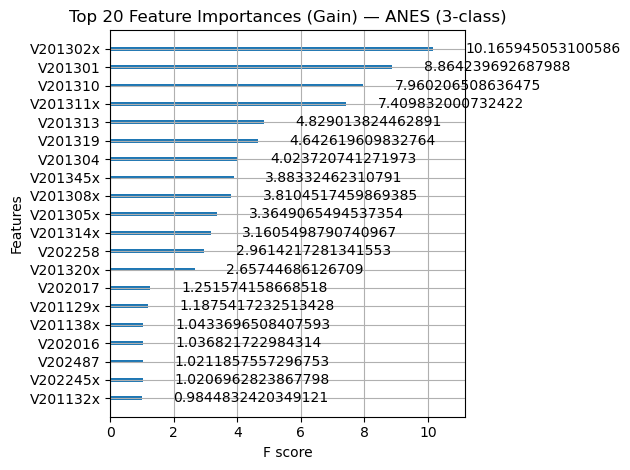

In [45]:
# --- 6) Top features (gain) ---
plt.figure(figsize=(10,6))
plot_importance(model, max_num_features=20, importance_type='gain')
plt.title("Top 20 Feature Importances (Gain) — ANES (3-class)")
plt.tight_layout(); plt.show()

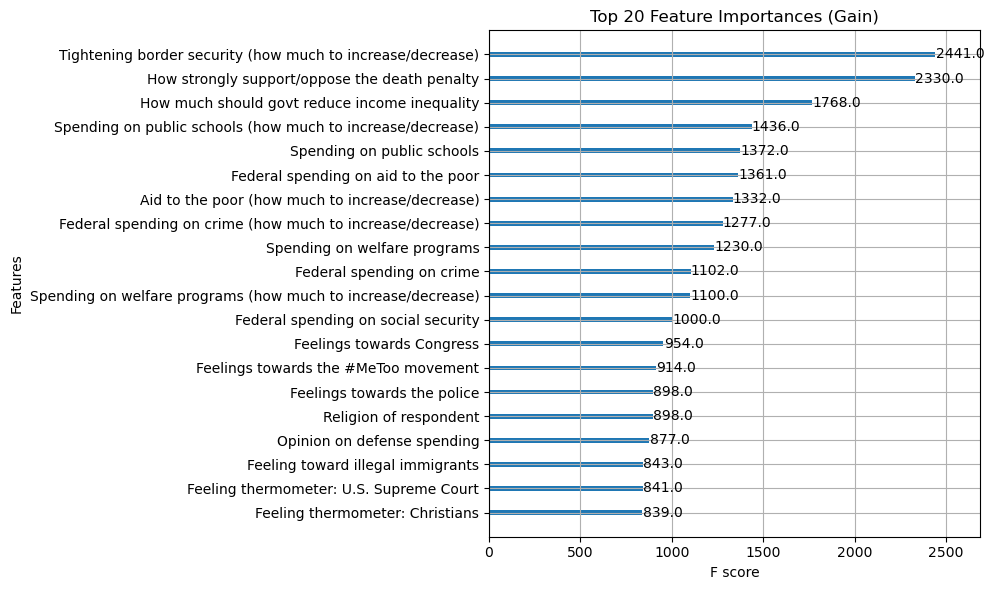

In [46]:
# Mini dictionary mapping variable codes → readable labels
var_labels = {
    "V202169":  "Feeling thermometer: Christians",
    "V201435":  "Religion of respondent",
    "V201250":  "Defence spending of Joe Biden",
    "V202481":  "Feeling toward illegal immigrants",
    "V202183":  "Feelings towards the #MeToo movement",
    "V202167":  "Feelings towards Congress",
    "V201249":  "Opinion on defense spending",
    "V202171":  "Feelings towards the police",
    "V201311x": "Federal spending on crime (how much to increase/decrease)",
    "V201310":  "Federal spending on crime",
    "V201302x": "Federal spending on social security",
    "V201313":  "Spending on welfare programs",
    "V202165":  "Feeling thermometer: U.S. Supreme Court",
    "V201320x": "Federal spending on aid to the poor",
    "V201304":  "Spending on public schools",
    "V201319":  "Aid to the poor (how much to increase/decrease)",
    "V201314x": "Spending on welfare programs (how much to increase/decrease)",
    "V201305x": "Spending on public schools (how much to increase/decrease)",
    "V202258":  "How much should govt reduce income inequality",
    "V201345x": "How strongly support/oppose the death penalty",
    "V201308x": "Tightening border security (how much to increase/decrease)"
   
}

def prettify(names):
    return [var_labels.get(n, n) for n in names]

# Plot with readable labels
from xgboost import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
plot_importance(model, max_num_features=20, ax=ax)

codes = [tick.get_text() for tick in ax.get_yticklabels()]
ax.set_yticklabels(prettify(codes))

ax.set_title("Top 20 Feature Importances (Gain)")
ax.set_xlabel("F score")
ax.set_ylabel("Features")
plt.tight_layout()
plt.show()


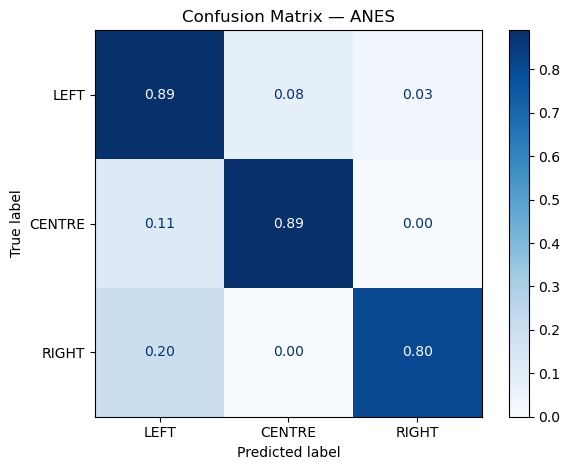

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = [0,1,2]
cm_norm = confusion_matrix(y_test, y_pred, labels=labels, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm,
                              display_labels=['LEFT','CENTRE','RIGHT'])
disp.plot(values_format='.2f', cmap='Blues')
plt.title('Confusion Matrix — ANES')
plt.tight_layout(); plt.show()

In [49]:
# Use the labels you already computed
y_anes_3 = df_model['ideology_class3'].astype(str)    # or df_subset['ideology_class3']

# If your block also checks X_anes, define it consistently:
X_anes = df_model[feature_cols].select_dtypes(include=[np.number]).fillna(0)

In [ ]:
from pathlib import Path

ART = Path("artifacts")
ART.mkdir(parents=True, exist_ok=True)

labels3_path = ART / "anes_train_labels_3.csv"

#Building to save 3-class labels
labels3_path = ART / "anes_train_labels_3.csv"
labels5_path = ART / "anes_train_labels_5.csv"

def collapse_to_3(s):
    s = (pd.Series(s).astype(str).str.upper().str.strip()
           .str.replace("CENTER","CENTRE", regex=False))
    return s.replace({
        "EXTREME LEFT":"LEFT", "EXTREME_LEFT":"LEFT",
        "EXTREME RIGHT":"RIGHT","EXTREME_RIGHT":"RIGHT"
    })


if labels3_path.exists():
    y_anes_3 = pd.read_csv(labels3_path)["label"].astype(str)
elif labels5_path.exists():
    y5 = pd.read_csv(labels5_path)["label"]
    y_anes_3 = collapse_to_3(y5)
elif "y_anes_3" in globals():
    y_anes_3 = collapse_to_3(globals()["y_anes_3"])
elif "y_anes_5" in globals():
    y_anes_3 = collapse_to_3(globals()["y_anes_5"])
else:
    raise KeyError("Couldn't find ANES labels. Provide y_anes_3 or y_anes_5, or export labels_5 first.")


y_anes_3 = y_anes_3.reset_index(drop=True)
X_anes = X_anes.reset_index(drop=True)
assert len(X_anes) == len(y_anes_3), f"Length mismatch: X={len(X_anes)} vs y={len(y_anes_3)}"

valid = {"LEFT","CENTRE","RIGHT"}
bad = set(y_anes_3.unique()) - valid
if bad:
    raise ValueError(f"Unexpected labels {bad}. Expected only {valid} after collapsing.")

y_anes_3.to_csv(labels3_path, index=False, header=["label"])
print("Saved labels_3:", labels3_path.name, "| counts:\n", y_anes_3.value_counts())

#collapsing into 3 class
if labels5_path.exists():
    try:
        labels5_path.unlink()
        print("Removed old 5-class labels:", labels5_path.name)
    except Exception as e:
        print("Note: could not remove old 5-class file:", e)

Saved labels_3: anes_train_labels_3.csv | counts:
 ideology_class3
CENTRE    3776
LEFT      3363
RIGHT     1138
Name: count, dtype: int64


In [ ]:
#Code for meta model
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)


xgb_base = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)


xgb_cal = CalibratedClassifierCV(xgb_base, method='isotonic', cv=5)
xgb_cal.fit(X_tr, y_tr)


proba_val  = xgb_cal.predict_proba(X_val)
proba_test = xgb_cal.predict_proba(X_test)
classes    = xgb_cal.classes_   # NOTE: these are the encoded labels from y (likely 0,1,2)


# If you used LabelEncoder with ['LEFT','CENTRE','RIGHT'], then LEFT == 0:
try:
    iL = int(np.where(classes == 0)[0][0])  # most likely
except Exception:
    # Fallback: if you have a LabelEncoder `le`, use this instead:
    # iL = int(np.where(classes == le.transform(['LEFT'])[0])[0][0])
    iL = 0  # last fallback; adjust if needed

best_d, best_f1 = 0.0, -1.0
for d in np.linspace(0.05, 0.40, 15):
    adj = proba_val.copy()
    adj[:, iL] = np.clip(adj[:, iL] - d, 0, 1)
    adj = adj / adj.sum(axis=1, keepdims=True)  # re-normalize after tweak
    y_hat = classes[adj.argmax(axis=1)]
    f1m = f1_score(y_val, y_hat, average='macro')
    if f1m > best_f1:
        best_f1, best_d = f1m, d

adj_test = proba_test.copy()
adj_test[:, iL] = np.clip(adj_test[:, iL] - best_d, 0, 1)
adj_test = adj_test / adj_test.sum(axis=1, keepdims=True)
y_pred = classes[adj_test.argmax(axis=1)]